# Generatic operators in permutation-based GA

### Define a permutation problem

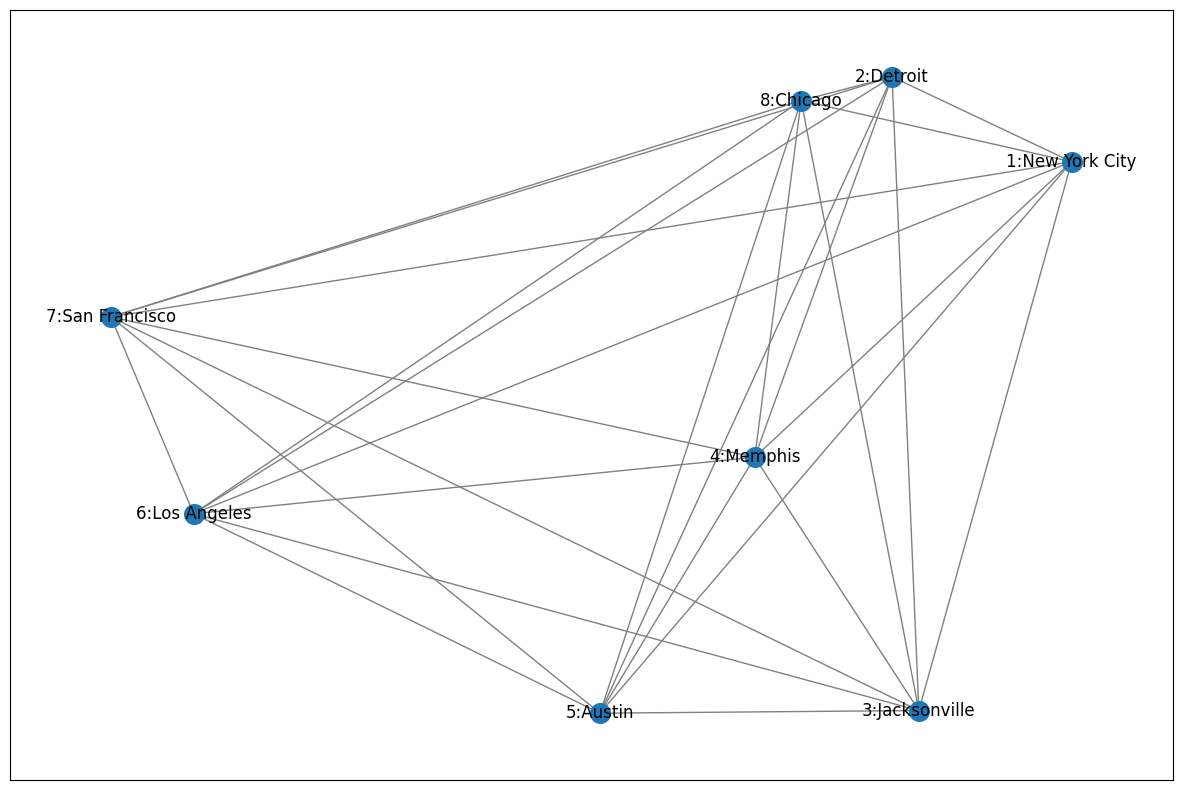

In [1]:
import networkx as nx
from collections import defaultdict
from haversine import haversine
import pandas as pd
import matplotlib.pyplot as plt

# latitude and longitude for the twenty largest U.S. cities
cities = {
    '1:New York City': (40.72, -74.00),
    '2:Detroit': (42.33, -83.05),
    '3:Jacksonville': (30.32, -81.70),
    '4:Memphis': (35.12, -89.97),
    '5:Austin': (30.27, -97.77),
    '6:Los Angeles': (34.05, -118.25),
    '7:San Francisco': (37.78, -122.42),
    '8:Chicago': (41.88, -87.63),
}


# create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 
        

# convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)
city_names=list(distances.columns)
distances=distances.values

# Visualize the cities and then route

# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()

 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()
# plt.savefig('CH08_F06_TSP.png', format='png', dpi=300)

### Visualize the candidate solutions (i.e., potential routes) as colored chromosomes

In [2]:
import random
import matplotlib.pyplot as plt

def generate_colored_chromosome(individual):
    colors = plt.cm.get_cmap('tab10', len(individual))
    chromosome = []
    for i, gene in enumerate(individual):
        color = colors(i)
        colored_gene = (gene, color)
        chromosome.append(colored_gene)
    return chromosome

def visualize_colored_chromosome(chromosome, title):
    fig, ax = plt.subplots(figsize=(5, 0.5))
    ax.axis('off')
    ax.axis('tight')

    cell_text = [[str(gene) for gene, color in chromosome]]
    cell_colours = [[color for gene, color in chromosome]]

    table = ax.table(cellText=cell_text,
                     cellColours=cell_colours,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.5)
    plt.title(title)
    plt.show()

### Given two parents 

These parents represent two candidate route between the cities startiing from city 1 (New York City) as a home city

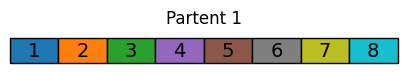

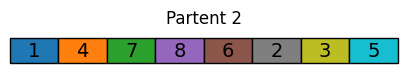

In [3]:
parent1 = [1, 2, 3, 4, 5, 6, 7, 8]
parent2 = [1, 4, 7, 8, 6, 2, 3, 5]

colored_chromosome1 = generate_colored_chromosome(parent1)
colored_chromosome2 = generate_colored_chromosome(parent2)
visualize_colored_chromosome(colored_chromosome1, 'Partent 1')
visualize_colored_chromosome(colored_chromosome2, 'Partent 2')

## Crossover Operators

### Partially Mapped Crossover (PMX)

This method creates offspring by combining the genetic information from two parents while preserving the feasibility of the resulting offspring.

In [4]:
import random

def partially_mapped_crossover(parent1, parent2):
    n = len(parent1)

    # Select two random crossover points
    point1, point2 = sorted(random.sample(range(n), 2))

    # Copy the segment between crossover points from the parents to the childern
    child1 = [None] * n
    child2 = [None] * n
    child1[point1:point2+1] = parent1[point1:point2+1]
    child2[point1:point2+1] = parent2[point1:point2+1]

    # Map the remaining elements from the other parent
    for i in range(n):
        if child1[i] is None:
            value = parent2[i]
            while value in child1:
                value = parent2[parent1.index(value)]
            child1[i] = value

        if child2[i] is None:
            value = parent1[i]
            while value in child2:
                value = parent1[parent2.index(value)]
            child2[i] = value

    return child1, child2

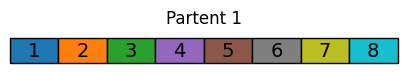

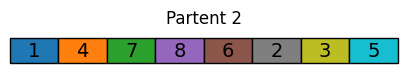

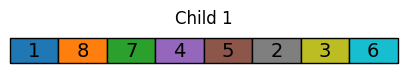

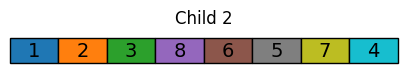

In [5]:
# apply the partially mapped crossover
child1, child2 = partially_mapped_crossover(parent1, parent2)

# visualize the parents and childern
colored_chromosome_p1 = generate_colored_chromosome(parent1)
colored_chromosome_p2 = generate_colored_chromosome(parent2)
visualize_colored_chromosome(colored_chromosome_p1, 'Partent 1')
visualize_colored_chromosome(colored_chromosome_p2, 'Partent 2')

colored_chromosome_c1 = generate_colored_chromosome(child1)
colored_chromosome_c2 = generate_colored_chromosome(child2)
visualize_colored_chromosome(colored_chromosome_c1, 'Child 1')
visualize_colored_chromosome(colored_chromosome_c2, 'Child 2')

### Edge Crossover (EC)

This method preserves the connectivity and adjacency information between elements from the parent chromosomes. 

In [6]:
import random

def edge_crossover(parent1, parent2):
    n = len(parent1)
    
    # Function to get adjacent elements of a given element in a parent
    def get_adjacents(parent, element):
        index = parent.index(element)
        return parent[(index - 1) % n], parent[(index + 1) % n]

    # Function to choose the next element in the childern
    def choose_next_element(adj1, adj2, childern):
        adj1 = [e for e in adj1 if e not in childern]
        adj2 = [e for e in adj2 if e not in childern]

        if adj1 and adj2:
            return random.choice(adj1 + adj2)
        elif adj1:
            return random.choice(adj1)
        elif adj2:
            return random.choice(adj2)
        else:
            remaining_elements = [e for e in range(n) if e not in childern]
            return random.choice(remaining_elements)

    childern = [parent1[0]]
    for _ in range(n - 1):
        adj1 = get_adjacents(parent1, childern[-1])
        adj2 = get_adjacents(parent2, childern[-1])
        next_element = choose_next_element(adj1, adj2, childern)
        childern.append(next_element)

    return childern

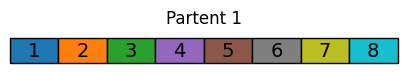

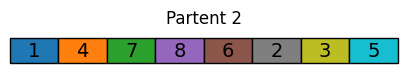

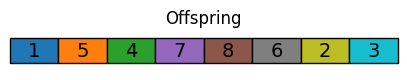

In [7]:
# apply the edge crossover
offspring = edge_crossover(parent1, parent2)

# visualize the parents and offspring
colored_chromosome1 = generate_colored_chromosome(parent1)
colored_chromosome2 = generate_colored_chromosome(parent2)
visualize_colored_chromosome(colored_chromosome1, 'Partent 1')
visualize_colored_chromosome(colored_chromosome2, 'Partent 2')

colored_chromosome_o = generate_colored_chromosome(offspring)
visualize_colored_chromosome(colored_chromosome_o, 'Offspring')

### Order 1 Crossover (OX1)

This method creates offspring by combining the genetic information from two parent chromosomes while preserving the relative order of elements in the resulting solutions

In [8]:
import random

def order_1_crossover(parent1, parent2):
    size = len(parent1)

    # Randomly select a subsequence from parent1
    start = random.randint(0, size - 1)
    end = random.randint(start + 1, size)

    # Initialize childern with None values
    child1 = [None] * size
    child2 = [None] * size

    # Copy the selected subsequence from parent1 to child1
    # and from parent2 to child2
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Fill the remaining positions in the childern
    for childern, parent in [(child1, parent2), (child2, parent1)]:
        pos = end
        for gene in parent[end:] + parent[:end]:
            if gene not in childern:
                while childern[pos % size] is not None:
                    pos += 1
                childern[pos % size] = gene
                pos += 1

    return child1, child2


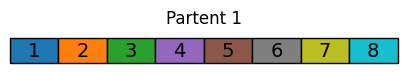

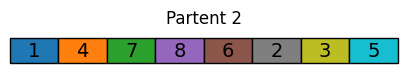

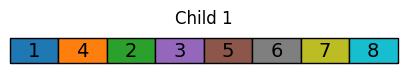

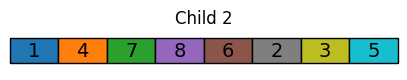

In [9]:
# apply order 1 crossover
child1, child2 = order_1_crossover(parent1, parent2)

# visualize the parents and childern
colored_chromosome_p1 = generate_colored_chromosome(parent1)
colored_chromosome_p2 = generate_colored_chromosome(parent2)
visualize_colored_chromosome(colored_chromosome_p1, 'Partent 1')
visualize_colored_chromosome(colored_chromosome_p2, 'Partent 2')

colored_chromosome_c1 = generate_colored_chromosome(child1)
colored_chromosome_c2 = generate_colored_chromosome(child2)
visualize_colored_chromosome(colored_chromosome_c1, 'Child 1')
visualize_colored_chromosome(colored_chromosome_c2, 'Child 2')

### Cycle Crossover (CX)

This operator divides the elements into cycles, where a cycle is a subset of elements that consistently appear together in pairs when the two parent chromosomes are aligned. 

In [10]:
import random

def find_cycle(parent1, parent2, visited, start):
    cycle = []
    current = start

    while current not in cycle:
        visited[current] = True
        cycle.append(current)
        current = parent1[parent2.index(current)]

    return cycle

def cycle_crossover(parent1, parent2):
    n = len(parent1)
    visited = {item: False for item in parent1}
    cycles = []

    for i in parent1:
        if not visited[i]:
            cycle = find_cycle(parent1, parent2, visited, i)
            cycles.append(cycle)

    child1 = [None] * n
    child2 = [None] * n

    for i, cycle in enumerate(cycles):
        if i % 2 == 0:
            for elem in cycle:
                child1[parent1.index(elem)] = elem
                child2[parent2.index(elem)] = elem
        else:
            for elem in cycle:
                child1[parent2.index(elem)] = elem
                child2[parent1.index(elem)] = elem

    return child1, child2

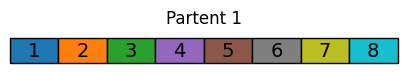

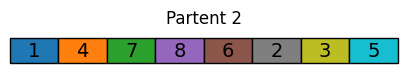

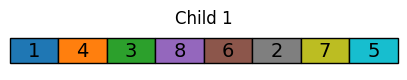

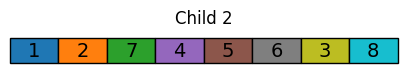

In [11]:
# apply cycle crossover
child1, child2 = cycle_crossover(parent1, parent2)

# visualize the parents and childern
colored_chromosome_p1 = generate_colored_chromosome(parent1)
colored_chromosome_p2 = generate_colored_chromosome(parent2)
visualize_colored_chromosome(colored_chromosome_p1, 'Partent 1')
visualize_colored_chromosome(colored_chromosome_p2, 'Partent 2')

colored_chromosome_c1 = generate_colored_chromosome(child1)
colored_chromosome_c2 = generate_colored_chromosome(child2)
visualize_colored_chromosome(colored_chromosome_c1, 'Child 1')
visualize_colored_chromosome(colored_chromosome_c2, 'Child 2')

## Mutation Operators

### Insert Mutation

* Pick two genes values at random,
* Move the second to follow the first, shifting the rest along to accommodate,
* This method primarily maintains the order and adjacency information of the genes.

In [12]:
import random

def insert_mutation(individual, mutation_rate):
    n = len(individual)
    mutated_individual = individual.copy()

    for i in range(n):
        if random.random() < mutation_rate:
            insert_index = random.randint(0, n-1)
            value_to_insert = mutated_individual.pop(i)
            mutated_individual.insert(insert_index, value_to_insert)

    return mutated_individual

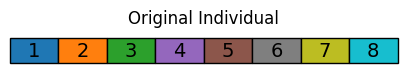

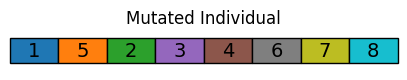

In [13]:
# Apply insert mutation
mutation_rate = 0.3
mutated_individual = insert_mutation(parent1, mutation_rate)

# visualize the parents and offspring
colored_chromosome_p1 = generate_colored_chromosome(parent1)
visualize_colored_chromosome(colored_chromosome_p1, 'Original Individual')

colored_chromosome_c1 = generate_colored_chromosome(mutated_individual)
visualize_colored_chromosome(colored_chromosome_c1, 'Mutated Individual')

### Swap Mutation

* Pick two genes at random and swap their positions,
* This method mainly retains adjacency information while causing more disruption to the original order.

In [14]:
import random

def swap_mutation(individual, mutation_rate):
    n = len(individual)
    mutated_individual = individual.copy()

    for i in range(n):
        if random.random() < mutation_rate:
            swap_index = random.randint(0, n-1)
            mutated_individual[i], mutated_individual[swap_index] = mutated_individual[swap_index], mutated_individual[i]

    return mutated_individual

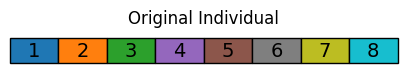

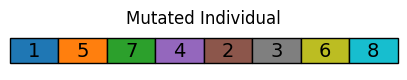

In [15]:
# Apply swap mutation
mutation_rate = 0.3
mutated_individual = swap_mutation(parent1, mutation_rate)

# visualize the parents and offspring
colored_chromosome_p1 = generate_colored_chromosome(parent1)
visualize_colored_chromosome(colored_chromosome_p1, 'Original Individual')

colored_chromosome_c1 = generate_colored_chromosome(mutated_individual)
visualize_colored_chromosome(colored_chromosome_c1, 'Mutated Individual')

### Inversion Mutation

* Randomly select two genes and invert the substring between them,
* This method largely maintains adjacency information but is disruptive to the order information.

In [16]:
import random

def inversion_mutation(individual, mutation_rate):
    n = len(individual)
    mutated_individual = individual.copy()

    if random.random() < mutation_rate:
        i, j = sorted(random.sample(range(n), 2))
        mutated_individual[i:j+1] = reversed(mutated_individual[i:j+1])

    return mutated_individual

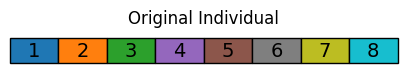

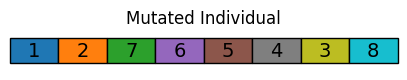

In [17]:
# Apply inversion mutation
mutation_rate = 0.9
mutated_individual = inversion_mutation(parent1, mutation_rate)

# visualize the parents and offspring
colored_chromosome_p1 = generate_colored_chromosome(parent1)
visualize_colored_chromosome(colored_chromosome_p1, 'Original Individual')

colored_chromosome_c1 = generate_colored_chromosome(mutated_individual)
visualize_colored_chromosome(colored_chromosome_c1, 'Mutated Individual')

### Scramble Mutation

* Randomly select two gene values,
* Rearrange the genes in the chosen positions non-contiguously, applying a random order.

In [18]:
import random

def scramble_mutation(individual, mutation_rate):
    n = len(individual)
    mutated_individual = individual.copy()

    if random.random() < mutation_rate:
        i, j = sorted(random.sample(range(n), 2))
        segment = mutated_individual[i:j+1]
        random.shuffle(segment)
        mutated_individual[i:j+1] = segment

    return mutated_individual

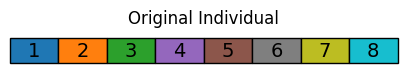

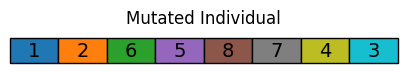

In [19]:
# Apply scramble mutation
mutation_rate = 0.7
mutated_individual = scramble_mutation(parent1, mutation_rate)

# visualize the parents and offspring
colored_chromosome_p1 = generate_colored_chromosome(parent1)
visualize_colored_chromosome(colored_chromosome_p1, 'Original Individual')

colored_chromosome_c1 = generate_colored_chromosome(mutated_individual)
visualize_colored_chromosome(colored_chromosome_c1, 'Mutated Individual')